In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles


In [2]:
dbFile = 'sims_featureScheduler_runs1.5/baseline/baseline_v1.5_10yrs.db'
# This connection checks which version it thinks the database is and should do the right thing schema-wise
conn = db.OpsimDatabase(dbFile)
outDir='temp'
resultsDb = db.ResultsDb(outDir=outDir)
runname='baseline_v1.5_10yrs'

In [3]:
bundleList = []
sql = ''
metric = metrics.PassMetric(cols=['observationStartMJD'])
ra=0
dec=-20
slicer = slicers.UserPointsSlicer(ra=ra,dec=dec)
plotDict = {'colorMax': 27.4}
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict))

In [4]:
bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()


Querying database SummaryAllProps with no constraint for columns ['fieldDec', 'fieldRA', 'observationStartMJD'].
Found 2224095 visits
Running:  ['opsim_Pass_observationStartMJD_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [5]:
bundleList[0].metricValues[0]['observationStartMJD']

array([63133.11891618, 60936.13737335, 60958.11878452, 60958.1022831 ,
       63133.10253145, 60936.15337955, 60580.25107148, 60164.22633592,
       62029.1450264 , 61275.2191845 , 61572.40036759, 63458.22458878,
       62104.10753163, 61624.28566641, 60464.42051983, 60202.15543648,
       60202.17225732, 61624.26941564, 60163.27899624, 60911.18258139,
       61572.40377773, 60246.15736309, 63485.20751157, 62029.12868093,
       63206.05160384, 63485.19152056, 60580.23495335, 60163.29552734,
       60524.30073614, 62029.29339108, 62432.99934791, 60524.31706557,
       60559.14651055, 60164.21026975, 60246.14268105, 61275.20293512,
       63206.06796519, 63458.20865094, 60911.19885956, 60559.16245447,
       62104.12341711, 62029.27736325, 62788.10405114, 62788.08745056,
       61720.01071652, 61720.01109847, 62032.12876707, 62032.14504044,
       61678.11084255, 61678.12675153, 61666.17175402, 61000.08280237,
       60911.21966705, 62350.31771253, 61258.29255541, 61324.09984704,
      

In [6]:
t = bundleList[0].metricValues[0]['observationStartMJD']
bins = np.arange(t.min(), t.max(), 5/60./24)
ts, _be = np.histogram(t, bins=bins)

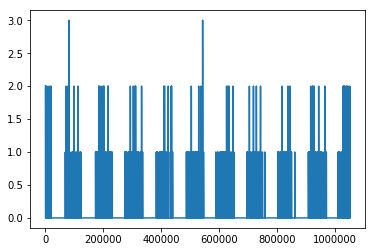

In [7]:
plt.plot(ts)

In [8]:
fourier = np.fft.fft(ts)
n = ts.size
timestep = (bins[1]-bins[0])*24.*3600  # to seconds
freq = np.fft.fftfreq(n, d=timestep)

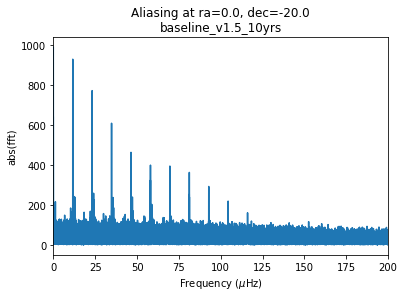

In [9]:
plt.plot(freq*1e6, np.abs(fourier))
#plt.plot(1./freq/3600./24., np.abs(fourier))
plt.xlim([0.000,0.0002*1e6])
#plt.ylim([0,50000])
plt.xlabel('Frequency ($\mu$Hz)')
#plt.xlabel('Period (days)')
plt.ylabel('abs(fft)')
plt.title('Aliasing at ra=%.1f, dec=%.1f\n%s' % (ra,dec, runname))

plt.savefig('alias_plots/aliasing.pdf')

In [10]:
peaks = freq[np.where(np.abs(fourier) > 200)]

In [11]:
periods = 1./peaks

/Users/yoachim/lsst/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


In [12]:
periods/3600.  # hours

array([            inf,  8.75752499e+03,  2.23977621e+02,  2.18392144e+02,
        2.39997944e+01,  2.39342033e+01,  2.38689697e+01,  2.23064824e+01,
        2.16235185e+01,  1.19834770e+01,  1.19671017e+01,  1.19507710e+01,
        1.15458471e+01,  1.13601310e+01,  7.98534238e+00,  7.97806777e+00,
        7.97080640e+00,  7.79555367e+00,  7.78862059e+00,  5.99173850e+00,
        5.98764187e+00,  5.98355083e+00,  5.97946538e+00,  5.88029611e+00,
        4.78945857e+00,  4.78684066e+00,  4.78422562e+00,  4.72052878e+00,
        3.99085171e+00,  3.98903389e+00,  3.98721772e+00,  3.42050736e+00,
        3.41917190e+00,  3.41783749e+00,  2.99279782e+00,  2.99177541e+00,
        2.66016372e+00,  2.65935592e+00, -2.65935592e+00, -2.66016372e+00,
       -2.99177541e+00, -2.99279782e+00, -3.41783749e+00, -3.41917190e+00,
       -3.42050736e+00, -3.98721772e+00, -3.98903389e+00, -3.99085171e+00,
       -4.72052878e+00, -4.78422562e+00, -4.78684066e+00, -4.78945857e+00,
       -5.88029611e+00, -

Looks like we've got a peak around 1-year (no surprise), and a big peak around 1, 0.997, 0.9945 days (so that looks like solar day and sidereal day, or maybe just centered on sidereal day). Then I guess those are harmonics at 1/2, 1/3, 1/4, 1/5. Maybe should also check a rolling cadence, but should be fine too I think.

Why does this look better than the minion_1016 from Bell et al paper? Could be spatial dithering helps a bit? Then there's no overlap region that gets hammered at preferential frequency.  Probably broader hour angle range than minion which was tipped over. 

The Bell et al paper point to a peak at 2.18 hours (that's the 11th harmonic of 24 hours)

In [13]:
periods/3600./24. + 4./60/24.

array([            inf,  3.64899652e+02,  9.33517866e+00,  9.10245046e+00,
        1.00276921e+00,  1.00003625e+00,  9.97318183e-01,  9.32214545e-01,
        9.03757715e-01,  5.02089319e-01,  5.01407013e-01,  5.00726570e-01,
        4.83854738e-01,  4.76116570e-01,  3.35500377e-01,  3.35197268e-01,
        3.34894711e-01,  3.27592514e-01,  3.27303636e-01,  2.52433549e-01,
        2.52262855e-01,  2.52092396e-01,  2.51922169e-01,  2.47790116e-01,
        2.02338551e-01,  2.02229472e-01,  2.02120512e-01,  1.99466477e-01,
        1.69063266e-01,  1.68987523e-01,  1.68911849e-01,  1.45298918e-01,
        1.45243274e-01,  1.45187673e-01,  1.27477687e-01,  1.27435087e-01,
        1.13617933e-01,  1.13584275e-01, -1.08028719e-01, -1.08062377e-01,
       -1.21879531e-01, -1.21922132e-01, -1.39632117e-01, -1.39687718e-01,
       -1.39743362e-01, -1.63356294e-01, -1.63431967e-01, -1.63507710e-01,
       -1.93910921e-01, -1.96564956e-01, -1.96673916e-01, -1.96782996e-01,
       -2.42234560e-01, -

In [14]:
1./(2.18*3600)*1e6


127.42099898063199